In [18]:
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns

In [3]:
# Pull the CSV and check out the layout.

raw_cars_df = pd.read_csv("../data/cars-dataset.csv")

raw_cars_df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
163,18.0,6,225.0,95.00,3785.0,19.0,75,1,plymouth fury
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
93,14.0,8,318.0,150.0,4237.0,14.5,73,1,plymouth fury gran sedan
31,25.0,4,113.0,95.00,2228.0,14.0,71,3,toyota corona
326,43.4,4,90.0,48.00,2335.0,23.7,80,2,vw dasher (diesel)
188,16.0,8,318.0,150.0,4190.0,13.0,76,1,dodge coronet brougham
222,17.0,8,260.0,110.0,4060.0,19.0,77,1,oldsmobile cutlass supreme
227,19.0,6,225.0,100.0,3630.0,17.7,77,1,plymouth volare custom
304,37.3,4,91.0,69.00,2130.0,14.7,79,2,fiat strada custom
391,36.0,4,135.0,84.00,2370.0,13.0,82,1,dodge charger 2.2


In [4]:
"""
The data is mostly good, but some of the horsepowers are missing. The dataset is small enough
that I don't want to just drop the whole row, but leaving the value set for "?" will cause problems.
So we're going to impute the missing values by replacing the "?" with mean/median horsepower values.

To reduce margin of error I'll use the mean values from the same origin and number of cylinders.
"""

# Replace "?" with NaN so we can use fillna() later
raw_cars_df['horsepower'] = raw_cars_df['horsepower'].replace('?', pd.NA)

# Convert horsepower to numeric, forcing errors to NaN
raw_cars_df['horsepower'] = pd.to_numeric(
    raw_cars_df['horsepower'], errors='coerce')

# This function will replace all the missing horsepower values with 
# mean values based on cylinder and origin.
# So like a 6 cylinder vehicle from Europe will get a mean of other 
# 6 cylinder horsepowers from europe.
def impute_missing_hp(row, grouped_means):
    if pd.isna(row['horsepower']):
        return grouped_means.loc[(row['cylinders'], row['origin'])]
    return row['horsepower']

# Calculate the mean horsepower for each cylinders-origin group
grouped_means = raw_cars_df.groupby(['cylinders', 'origin'])[
    'horsepower'].mean()

# Use the imput_missing_hp function on every row
raw_cars_df['horsepower'] = raw_cars_df.apply(
    lambda row: impute_missing_hp(row, grouped_means), axis=1)

all_cars_df = raw_cars_df

all_cars_df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
133,16.0,6,250.0,100.0,3781.0,17.0,74,1,chevrolet chevelle malibu classic
226,20.5,6,231.0,105.0,3425.0,16.9,77,1,buick skylark
88,14.0,8,302.0,137.0,4042.0,14.5,73,1,ford gran torino
322,46.6,4,86.0,65.0,2110.0,17.9,80,3,mazda glc
284,20.6,6,225.0,110.0,3360.0,16.6,79,1,dodge aspen 6
246,32.8,4,78.0,52.0,1985.0,19.4,78,3,mazda glc deluxe
335,35.0,4,122.0,88.0,2500.0,15.1,80,2,triumph tr7 coupe
157,15.0,8,350.0,145.0,4440.0,14.0,75,1,chevrolet bel air
260,18.6,6,225.0,110.0,3620.0,18.7,78,1,dodge aspen
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [5]:
# Here's a separate dataframe for each origin.

american_cars_df = all_cars_df[all_cars_df['origin']== 1]

european_cars_df = all_cars_df[all_cars_df['origin'] == 2]

japanese_cars_df = all_cars_df[all_cars_df['origin'] == 3]

american_cars_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,151.0,90.0,2950.0,17.3,82,1,chevrolet camaro
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [6]:
# These should be gone now.
missing_hp_df = all_cars_df[all_cars_df['horsepower']=='?']

missing_hp_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name


<Axes: xlabel='model'>

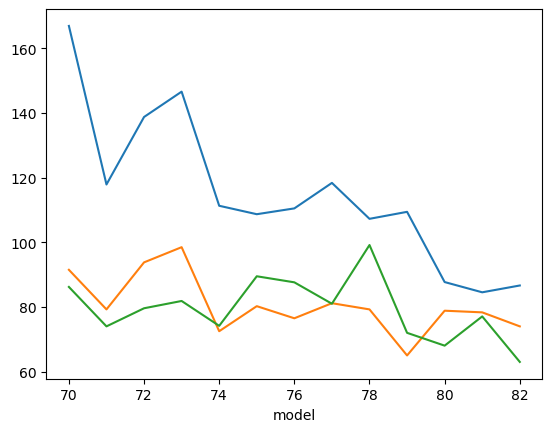

In [33]:
mean_american_hp_df = american_cars_df.groupby("model")["horsepower"].mean()
mean_american_hp_df
mean_european_hp_df = european_cars_df.groupby("model")["horsepower"].mean()
mean_japanese_hp_df = japanese_cars_df.groupby("model")["horsepower"].mean()
# seven_df = american_cars_df[american_cars_df['model'] == 70].horsepower.mean()
# seven_df
mean_american_hp_df.plot.line()
mean_japanese_hp_df.plot.line()
mean_european_hp_df.plot.line()

# sns.lineplot(data=mean_american_hp_df)
# sns.lineplot(data=mean_european_hp_df)
# sns.lineplot(data=mean_japanese_hp_df)


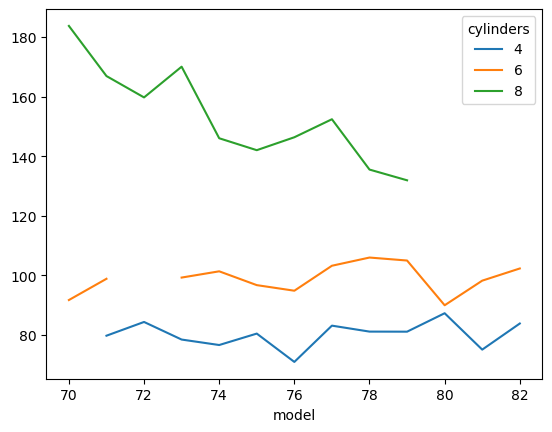

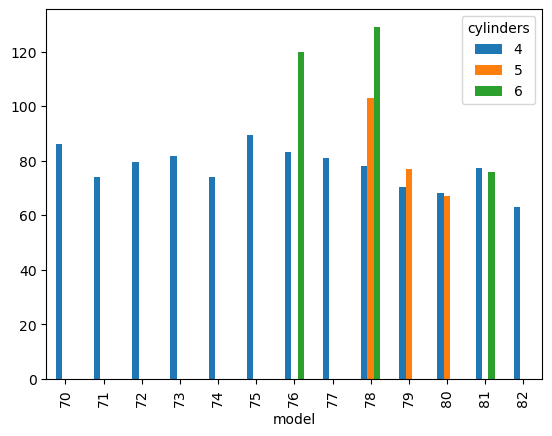

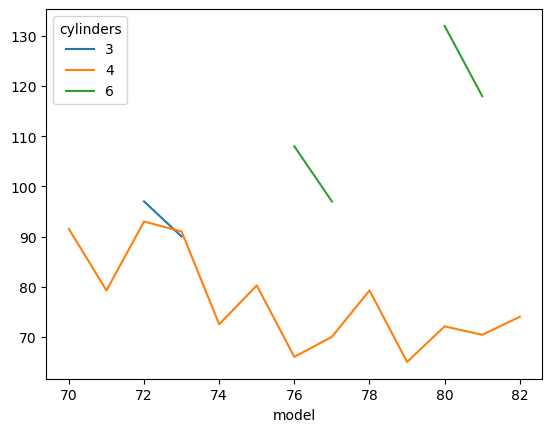

In [54]:
mean_american_hp_cyl_df = american_cars_df.groupby(["model",'cylinders'])["horsepower"].mean()
mean_american_hp_cyl_df
mean_european_hp_cyl_df = european_cars_df.groupby(["model",'cylinders'])["horsepower"].mean()
mean_japanese_hp_cyl_df = japanese_cars_df.groupby(["model",'cylinders'])["horsepower"].mean()


ax = mean_american_hp_cyl_df.unstack(level=1).plot.line()
ax = mean_european_hp_cyl_df.unstack(level=1).plot.bar()
ax = mean_japanese_hp_cyl_df.unstack(level=1).plot.line()

In [60]:
american_cars_df["cylinders"].value_counts()


cylinders
8    103
6     74
4     72
Name: count, dtype: int64

<Axes: xlabel='model'>

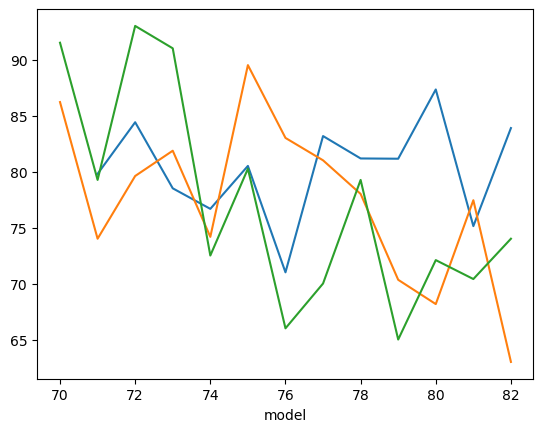

In [63]:
european_cars_df["cylinders"].value_counts()
japanese_cars_df["cylinders"].value_counts()
four_cylinder_american = american_cars_df[american_cars_df["cylinders"] == 4]
four_cylinder_euro = european_cars_df[european_cars_df["cylinders"] == 4]
four_cylinder_japan = japanese_cars_df[japanese_cars_df["cylinders"] == 4]
mean_four_cyl_am = four_cylinder_american.groupby("model")["horsepower"].mean()
mean_four_cyl_eu = four_cylinder_euro.groupby("model")["horsepower"].mean()
mean_four_cyl_jp = four_cylinder_japan.groupby("model")["horsepower"].mean()

mean_four_cyl_am.plot.line()
mean_four_cyl_eu.plot.line()
mean_four_cyl_jp.plot.line()